In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import h5py
import numpy as np
import scipy.io

import tempfile, sys, os
sys.path.insert(0, os.path.abspath('..'))

from keras.models import Model
from keras.constraints import max_norm,MinMaxNorm,NonNeg
from keras.regularizers import L1L2
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU, BatchNormalization
from keras.layers import Convolution1D, MaxPooling1D 
from keras.layers.core import Flatten
from sklearn import metrics
from sklearn.metrics import mean_squared_error

import matplotlib
matplotlib.get_backend()
from matplotlib import pyplot as plt
import random
np.random.seed(12345)

In [84]:
MODELFILE = "example/E118.model.hdf5"
DATAFILE = "example/E118.seqdata.hdf5"
MOTIFFILE = "example/E118.CNN1_motif.hdf5"

In [80]:
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

def map2recall(yv,ypred, ytarget): 

    rr = np.zeros_like(yv)
    ff1 = np.zeros_like(yv)
    pp = np.zeros_like(yv)
    print(rr.shape)

    fd = 1
    print(fd)
    
    for i in range(3):
        pj = np.where(ytarget[:,i]>0)[0]
        nj = np.where(ytarget[:,i]==0)[0]
        njr = shuffle(nj,random_state=0)
        njr = njr[:fd*(pj.shape[0])]
        k = np.concatenate((pj,njr),axis=0)

        fpr, tpr, throc = roc_curve(ytarget[k,i], ypred[k,i])
        precision, recall, thpr = precision_recall_curve(ytarget[k,i], ypred[k,i])
        f1 = 2*(precision*recall)/(precision+recall)
    
        for j in range(1,100): #,0,-1):
            mi = np.where(recall<j/100)[0]
            mi1 = thpr[mi-1]
            k = np.where(yv[:,i]<mi1[0])[0]
            rr[k,i] = j/100
            ff1[k,i] = f1[mi[0]]
            pp[k,i] = precision[mi[0]]
            
    return (rr, ff1, pp)

In [95]:
def calculatePWM(CNN1_output,x):

###########generate motif1 PWM maxtrix by using all samples
    nkernels = CNN1_output.shape[2]
    
    axx = np.empty(shape=[0,nkernels,110,4])
    abx = np.empty(shape=[0,110,4])

    for i in np.arange(50,940,2):
        
        if i%50==0:
            print("proceeding pass", i)
            
        mi = CNN1_output[:,i,:]
        smi = mi.sum(axis=0)
        a = np.matmul(x[:,(i-50):(i+60),:].T,mi)
        b = np.transpose(a, (2, 1, 0))
        c = b/smi[:,None,None]
        c[np.where(smi==0),:,:] = 0
        
        cbx = x[:,(i-50):(i+60),:].mean(axis=0)
        axx = np.concatenate((axx,c[np.newaxis,:]),axis=0)
        abx = np.concatenate((abx,cbx[np.newaxis,:]),axis=0)

    return axx,abx


In [99]:
import logomaker as lgm
import pandas as pd

def plotLogo(cxxt, cbxt, rs, stIndex, endIndex,cstr):
    
    bb1 = np.empty(shape=[0,110])
    for k in range(stIndex,endIndex):
        
        cx = (cxxt[:,rs[k],:,:]/cbxt-1)
    
        g1 = (cx[:,:cstr-3,:]).max(axis=1)
        g2 = (cx[:,-cstr+3:,:]).max(axis=1)
        g = np.concatenate((g1[None,:,:],g2[None,:,:]),axis=0).max(axis=0)+1e-5
        
        cx[cx<0] = 0
        cx[cx<g[:,None,:]] = 0
        cx = cx.mean(axis=0)
        
        c = cx.sum(axis=1)
        cx[c<0.1,:] = 0
        bb1 = np.concatenate((bb1,c[np.newaxis,:]),axis=0)
               
        cx = cx[cstr:-cstr,:]        
        dcx = pd.DataFrame(200*cx, columns = ['A','C','G','T'])
        dfinfo = lgm.transform_matrix(dcx, from_type='counts', to_type='information')
        t = lgm.Logo(dfinfo,width=1,vpad=.01,figsize=(5,1))
        t.style_spines(spines=['left', 'right','top'], visible=False)
        t.fig.show()
      

Matplotlib is building the font cache; this may take a moment.


In [100]:
def printPWM(cxxt, cbxt, stampflg, rs, motifval, filename, stIndex, endIndex, cstr):

    file1 = open(filename,"w") 
    L = ""
    
    for k in range(stIndex,endIndex):
        
        cx = (cxxt[:,rs[k],:,:]/cbxt-1)
    
        g1 = (cx[:,:cstr-3,:]).max(axis=1)
        g2 = (cx[:,-cstr+3:,:]).max(axis=1)
        g = np.concatenate((g1[None,:,:],g2[None,:,:]),axis=0).max(axis=0)+1e-5
        
        cx[cx<g[:,None,:]] = 0
        cx[cx<0] = 0
        cx = cx.mean(axis=0)
        c = cx.sum(axis=1)
        cx[c<0.1,:] = 0
       
        cx = cx[cstr:-cstr,:]        
        cx = np.around(cx*200)
        
        dcx = pd.DataFrame(200*cx, columns = ['A','C','G','T'])
        dfinfo = lgm.transform_matrix(dcx, from_type='counts', to_type='probability')
        dfinfo = np.round(dfinfo,3)
        
        
        if stampflg == 1:
            L = L + ">motif" + str(k) + "::" + str(motifval[rs[k]])+"\n"
            for j in range(dfinfo.shape[0]):
                L = L + "\t".join(str(f) for f in dfinfo.iloc[j]) + "\n"
        else:
            L = L + "MOTIF" + str(k) + "::" + str(motifval[rs[k]])+"\n"
            L = L + "letter-probability matrix: alength= 4 w= 10 nsites= 17 E= 4.1e-009" + "\n" 
            for j in range(dfinfo.shape[0]):
                L = L + "\t".join(str(f) for f in dfinfo.iloc[j]) + "\n"
            L = L+"\n"
            
    file1.writelines(L)
    file1.close() 

In [85]:
print('build model ...')
model = Sequential()
model.add(Convolution1D(480, 9, activation='relu',input_shape=(1000,4),
                        kernel_regularizer=L1L2(l1=1e-8, l2=5e-7),kernel_constraint=max_norm(1)),name="CNN1")
model.add(BatchNormalization())
model.add(LeakyReLU(0))
model.add(MaxPooling1D(9, 3))
model.add(Dropout(0.2))
model.add(Convolution1D(480, 4, activation='relu',
                        kernel_regularizer=L1L2(l1=1e-8, l2=5e-7),kernel_constraint=max_norm(0.9)))
model.add(BatchNormalization())
model.add(LeakyReLU(0))
model.add(MaxPooling1D(4, 2))
model.add(Dropout(0.2))
model.add(Convolution1D(240,4,activation='relu',
                        kernel_regularizer=L1L2(l1=1e-8, l2=5e-7),kernel_constraint=max_norm(1)))
model.add(MaxPooling1D(4, 3))
model.add(Dropout(0.2))
model.add(Convolution1D(320,4, activation='relu',
                        kernel_regularizer=L1L2(l1=1e-8, l2=5e-7),kernel_constraint=max_norm(1)))
model.add(BatchNormalization())
model.add(LeakyReLU(0))
model.add(MaxPooling1D(4, 3))
model.add(Convolution1D(320,4, activation='relu',
                        kernel_regularizer=L1L2(l1=1e-8, l2=5e-7),kernel_constraint=max_norm(1)))
model.add(BatchNormalization())
model.add(LeakyReLU(0))
model.add(MaxPooling1D(4, 3))
model.add(Flatten())
model.add(Dense(180, activation='sigmoid',
                kernel_regularizer=L1L2(l1=1e-8, l2=5e-7),kernel_constraint=max_norm(1)))
model.add(Dense(3, activation='sigmoid',
                kernel_regularizer=L1L2(l1=1e-8, l2=5e-7),kernel_constraint=max_norm(1)))

for layer in model.layers: 
    layer.trainable = False

model.load_weights(MODELFILE)
print(model.summary())


build model ...
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 992, 480)          17760     
_________________________________________________________________
batch_normalization_16 (Batc (None, 992, 480)          1920      
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 992, 480)          0         
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 328, 480)          0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 328, 480)          0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 325, 480)          922080    
_________________________________________________________________
batch_normalization_17 (Batc (None, 32

In [156]:
f = h5py.File(DATAFILE, 'r')
print("Keys: %s" % f.keys())
x = f['x'][:]
f.close()

Keys: <KeysViewHDF5 ['x']>


In [86]:
#### output of the layer CNN1
motif_model = Model(inputs=model.input, outputs=model.get_layer('CNN1').output)
motif1_output = motif_model.predict(xt,batch_size=100, verbose=1)

3790/3790 [==============================] - 314s 80ms/step


In [96]:
#### MOTIF calculation based on the layer CNN1

cnnx,cnnbx = calculatePWM(motif1_output,x)

<ipython-input-95-251c19520edb>:18: RuntimeWarning: invalid value encountered in true_divide
  c = b/smi[:,None,None]


60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920


In [150]:
##### Build MOTIF PWMs with the example of CNN1 outputs

f = h5py.File(MOTIFFILE, 'r')
cnnx = f['cnnx'][:].T
cnnbx = f['cnnbx'][:].T
f.close()

Keys: <KeysViewHDF5 ['cnnbx', 'cnnx']>


<ipython-input-99-772abb0b02c5>:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  t.fig.show()


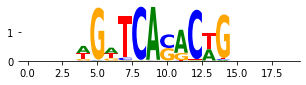

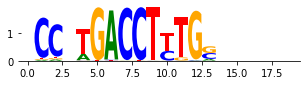

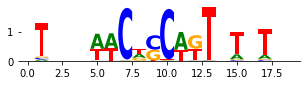

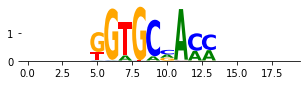

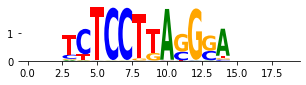

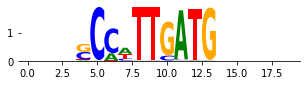

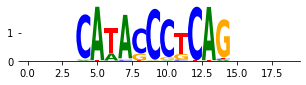

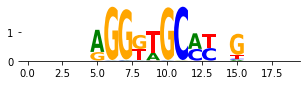

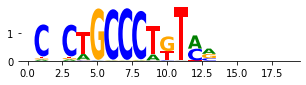

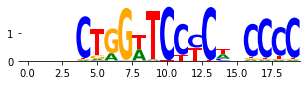

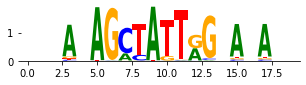

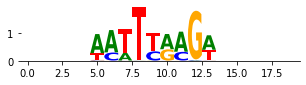

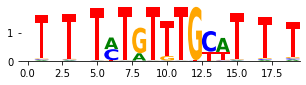

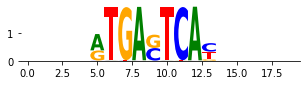

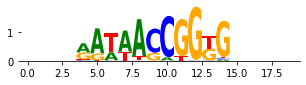

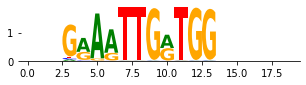

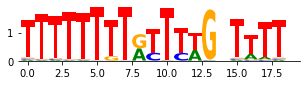

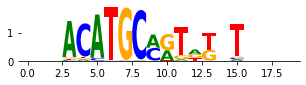

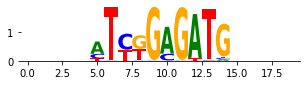

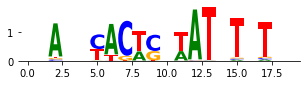

In [153]:
#### print motif webLOGO 

sel = np.arange(20) ### the MOTIFs encoded in the first 20 CNN kernels
plotLogo(cnnx, cnnbx, sel, 0, sel.shape[0],45)